# Music

Data borrowed from here: https://github.com/mcleavey/musical-neural-net/  
http://www.christinemcleavey.com/files/notewise_piano_solo.tar.gz  
http://www.christinemcleavey.com/files/jazz.tar.gz  
http://www.christinemcleavey.com/files/notewise_chamber.tar.gz  

Notebook is a combined implementation from:
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb  
https://github.com/mcleavey/musical-neural-net/blob/master/train.py

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
class MusicTokenizer():
    def __init__(self):
        super().__init__()
        self.n_cpus = num_cpus()
        
    def process_text(self, t:str) -> List[str]:
        return t.split(" ")
    
    def _process_all_1(self, texts:Collection[str]) -> List[List[str]]:
        return [self.process_text(t) for t in texts]

    def process_all(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts`."
        if self.n_cpus <= 1: return self._process_all_1(texts)
        with ProcessPoolExecutor(self.n_cpus) as e:
            return sum(e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus)), [])


In [4]:
path = Path('data/composers/notewise/piano_solo/note_range38/sample_freq12')
path.ls()[:5]

[PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/jazz'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/ravel'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/bach'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/schumann'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/liszt')]

In [5]:
bs=32

In [6]:
if (path/'tmp/itos.pkl').exists():
# if False:
    data = TextLMDataBunch.load(path, bs=bs)
else:
    p = [OpenFileProcessor(), TokenizeProcessor(tokenizer=MusicTokenizer(), chunksize=10), NumericalizeProcessor(vocab=None, max_vocab=500)]

    data = (TextList.from_folder(path, recurse=True, processor=p)
            .random_split_by_pct(0.05, seed=6)
            .label_for_lm()
            .databunch(bs=bs))
    data.save('tmp')
vocab = data.train_ds.vocab
len(data.train_ds), len(data.valid_ds), len(data.train_ds.vocab.itos)

(1798, 94, 110)

It only contains one csv file, let's have a look at it.

In [7]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2,  94,  94,  94, ...,   9,  53,   9, 109]))

In [8]:
data.show_batch()

idx,text
0,xxbos p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1 p15 p17 wait6 p15 p17 wait5 endp15 endp17 wait1 p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1 p15 p17 wait6 p15 p17 wait5 endp15 endp17 wait1 p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1
1,wait1 p6 wait8 p2 endp6 wait2 endp2 wait2 p3 p4 p6 p8 p11 wait3 endp11 wait2 endp3 endp6 endp8 wait3 p3 p6 p8 p11 wait1 p4 wait1 endp3 endp11 wait1 endp6 endp8 wait1 p3 p11 wait3 p6 p8 p11 wait2 endp3 wait3 endp4 endp6 endp8 endp11 wait4 p3 p4 p6 p8 p11 wait5 endp3 endp6 endp8 endp11 wait2 endp4 wait2 p2 p3 p6 p8 p11 wait2 endp2 wait1 p3 p4
2,endp18 wait1 p9 wait5 endp9 wait1 p1 wait6 p1 wait6 p1 wait5 endp1 endp25 endp33 wait1 p11 p23 p32 wait3 endp23 endp32 wait1 p25 p33 wait1 endp11 wait1 p17 endp25 endp33 wait2 p23 p32 wait3 endp17 endp23 endp32 wait1 p21 p25 p30 wait5 endp25 wait1 p17 wait5 endp17 wait1 p11 wait5 endp11 endp21 endp30 wait1 p1 p20 p29 wait5 endp1 endp20 endp29 wait1 p6 p21 p30 wait6 p1 wait1 endp6
3,endp36 wait1 p32 wait5 endp32 wait1 p33 wait5 endp33 wait1 p29 wait5 endp29 wait1 p28 wait11 endp28 wait1 p20 p23 p26 wait11 endp20 endp23 endp26 wait1 p21 p24 wait11 endp21 endp24 wait1 p29 wait11 endp29 wait1 p14 p21 p23 wait11 endp14 wait1 p15 p21 p23 wait11 endp15 endp21 endp23 wait1 p16 p20 p24 wait2 endp24 wait1 p23 wait1 p21 wait2 endp21 p23 wait5 endp16 endp20 endp23 wait1 p4 wait6 p23
4,endp5 endp12 wait3 p15 wait3 p9 endp15 wait3 endp9 p12 wait3 endp12 wait3 p3 p17 wait3 endp17 p21 wait3 p1 endp21 p22 wait1 endp3 wait4 endp22 wait1 p17 wait1 endp1 wait2 p0 endp17 p24 wait3 p17 wait2 endp24 wait1 endp17 wait1 endp0 wait2 p10 p25 wait3 p22 wait3 endp22 wait2 p20 wait3 endp20 wait1 p18 wait3 endp10 endp18 p20 wait3 endp20 wait1 endp25 wait1 p23 wait3 endp23 wait1 p17 wait3


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

Now let's grab the full dataset for what follows.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [9]:
# data_lm = (TextList.from_folder(path)
#            #Inputs: all the text files in path
#             .filter_by_folder(include=['train', 'test', 'unsup']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .random_split_by_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly
#             .databunch(bs=bs))
# data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [9]:
learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=200)

In [10]:
learn = learn.to_fp16()

In [ ]:
learn.lr_find(num_it=1000)

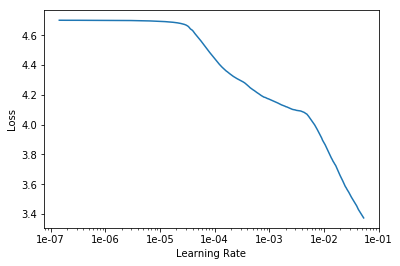

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
# From old code
# learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)    # Applying regularization
# learner.clip=0.3                                          # Clip the gradients  

In [ ]:
learn.fit_one_cycle(1, 2e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot()

In [15]:
learn.save('fit_head')

In [16]:
learn.load('fit_head');

In [18]:
out = learn.pred_batch()

In [19]:
learn.show_results()

text,target,pred
xxbos wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35,endp20 endp35 wait7 p20 p35 wait8 endp20 endp35 wait4 p18 p33 wait5 endp18 endp33 wait19 p15 p30 wait5 endp15 endp30,endp20 endp35 wait1 p21 p32 wait5 endp20 endp35 wait4 p20 p30 wait5 endp18 endp33 wait1 p18 p30 wait5 endp15 endp30
endp23 endp30 wait1 p9 p11 wait5 endp9 wait1 p4 p7 p11 p16 wait6 p7 p11 p16 wait5 endp7 wait1 p11,p19 wait5 endp16 endp19 wait1 p11 p18 p21 wait5 endp18 endp21 wait1 p4 p11 p16 p19 p23 wait5 endp11 endp19,p19 wait5 endp11 wait1 wait1 p4 p23 p23 wait5 endp11 endp21 wait1 p4 p7 p16 p19 wait5 wait5 endp4 endp16
wait5 endp16 wait1 p14 wait5 endp19 wait1 p9 wait5 endp9 wait1 p19 wait5 endp14 wait1 p12 wait5 endp19 wait1 p17,endp17 wait1 p19 wait5 endp12 wait1 p11 wait5 endp19 wait1 p16 wait5 endp16 wait1 p19 wait5 endp11 wait1 p9 wait5,endp12 wait1 p16 wait5 endp19 endp19 p14 wait5 endp11 wait1 p17 wait5 endp11 wait1 p17 wait5 endp19 endp19 p12 p24
endp16 endp21 endp28 wait1 p19 p22 p24 wait5 endp19 endp22 wait1 p12 p18 p21 wait2 endp12 endp18 endp21 wait4 p12,p21 wait2 endp12 endp18 endp21 wait4 p4 p12 wait2 endp4 endp12 wait4 p33 wait11 endp33 wait1 p18 p21 p24 wait2,p21 p24 endp12 endp18 endp21 wait4 p12 wait2 p18 endp4 endp12 wait4 p12 wait2 endp33 wait1 p12 endp18 p24 p27
endp8 wait1 p10 wait1 p11 wait1 endp10 wait1 endp11 p13 p19 endp19 p31 endp31 wait2 p11 endp13 wait1 p10 wait1,wait1 endp10 wait1 p8 p20 endp20 p32 endp32 wait2 endp8 wait4 p3 p32 endp32 wait2 endp3 p5 wait1 p7 wait1,wait1 endp10 wait1 p11 wait2 wait2 p22 endp32 wait2 endp8 wait1 p10 endp3 endp32 wait1 endp3 p8 wait1 p8 p31


### Testing

In [12]:
file = path.ls()[0].ls()[0]

In [13]:
with open(file, 'r') as f:
    txt_out = f.read()

In [14]:
notes = txt_out.split(' ')

In [15]:
subsample = ' '.join(notes[:100])

### Generate from predictions

In [20]:
from utils import *

In [24]:
stream = 'wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35'

In [50]:
result = write_mid_mp3_wav(stream, fname='test2.mp3', sample_freq=12, note_offset=38, out=path, chordwise=False)

In [52]:
out = path/'test2.mp3'

In [53]:
import IPython
IPython.display.Audio(str(out))

### Midi Tutorials

In [19]:
from music21 import *
import random
keyDetune = []
for i in range(0, 127):
    keyDetune.append(random.randint(-30, 30))

b = corpus.parse('bach/bwv66.6')
# for n in b.flat.notes:
#     n.microtone = keyDetune[n.midi]
sp = midi.realtime.StreamPlayer(b)

In [21]:
sp.play()

KeyboardInterrupt: 

In [22]:
n = b.flat.notes

In [64]:
cs = n[0]

In [ ]:
cs.me

In [55]:
import random
keyDetune = []
for i in range(127):
    keyDetune.append(random.randint(-30, 30))

In [56]:
b = corpus.parse('bwv66.6')
for n in b.flat.notes:
    n.pitch.microtone = keyDetune[n.pitch.midi]
sp = midi.realtime.StreamPlayer(b)
sp.play()

NameError: name 'corpus' is not defined

### Previous notebook cells

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.949835,3.892163,0.309857
2,3.863976,3.823716,0.319508
3,3.827637,3.776987,0.325163
4,3.782025,3.738658,0.329756
5,3.704519,3.705750,0.333159
6,3.658038,3.682820,0.335856
7,3.608049,3.662626,0.338366
8,3.552923,3.648938,0.340119
9,3.518708,3.642814,0.340864
10,3.480421,3.641818,0.340905


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was clearly a movie . xxmaj so i gave it a 2 out of 10 . xxmaj so , just say something . xxbos xxmaj this is a really stunning picture , light years off of the late xxmaj
i liked this movie because it would be a good one for those who like deep psychological and drama and you can go see this movie if you like a little slow motion and some magic should n't be there . i would give it


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')